# Thrombin ligands for pharmacophore identification

We explore thrombing ligands that will be used to create ligand-based pharmacophore models

In [1]:
import openpharmacophore as oph

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import nglview as nv

from collections import defaultdict
from pprint import pprint
import os

from IPython.display import SVG
from tqdm.auto import tqdm

from read_sdf import read_sdf

## Load  and visualize ligands

We load the ligands from their respective smiles and draw their molecular structures

In [2]:
lig_df = pd.read_csv("ligands.csv")
lig_df

,Smiles,PDBID,LigID
0,[H]/N=C(\C1CCC(CC1)CNC(=O)[C@@H]2C=C(CN3N2C(=O...,1C4V,IH2
1,CN[C@H](Cc1ccccc1)C(=O)N2CCC[C@H]2C(=O)NCC3CCC...,1TOM,MIN
2,c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O...,1D6W,00R
3,c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O...,1D91,00P
4,[H]/N=C(/c1ccc(cc1)C[C@H](C(=O)N2CCCCC2)NC(=O)...,1DWD,MID
5,[H]/N=C(\c1ccc2c(c1)cc([nH]2)C(=O)N3CCC(CC3)Cc...,1D4P,BPP


In [3]:
def load_ligands():
    """ Load the ligands into a list of rdkit molecules."""
    ligands = []
    
    smiles = lig_df["Smiles"]
    pdb_ids = lig_df["PDBID"]
    
    for ii in range(len(smiles)):
        mol = Chem.MolFromSmiles(smiles[ii].encode("unicode_escape"))
        mol.SetProp("_Name", pdb_ids[ii])
        assert mol is not None
        ligands.append(mol)
    
    supp = Chem.SDMolSupplier("0ZI.sdf")
    mol = next(supp)
    mol.RemoveAllConformers()
    mol.SetProp("_Name", "1FPC")
    ligands.append(mol)

    print(f"Num ligands: {len(ligands)}")
    return ligands

Num ligands: 7


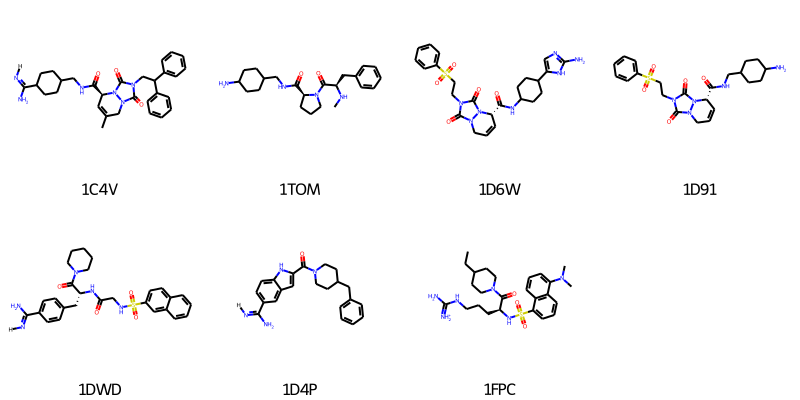

In [4]:
ligands = load_ligands()
legends = [l.GetProp("_Name") for l in ligands]
Draw.MolsToGridImage(ligands, legends=legends, molsPerRow=4)

## Preparing the ligands

We'll generate different conformers for each of the ligands and add hydrogens to them
as well.

In [5]:
pharmacophore = oph.LigandBasedPharmacophore()
pharmacophore.ligands = ligands

### Generating conformers

In [6]:
# Load conformers from file if present
conf_file = "./thrombin_ligands.sdf"
if os.path.isfile(conf_file):
    pharmacophore.ligands = read_sdf(conf_file)
else:
    pharmacophore.generate_conformers(n_confs=-1, ligands="all")
    
print([l.GetNumConformers() for l in pharmacophore.ligands])

[178, 171, 164, 153, 170, 42, 281]


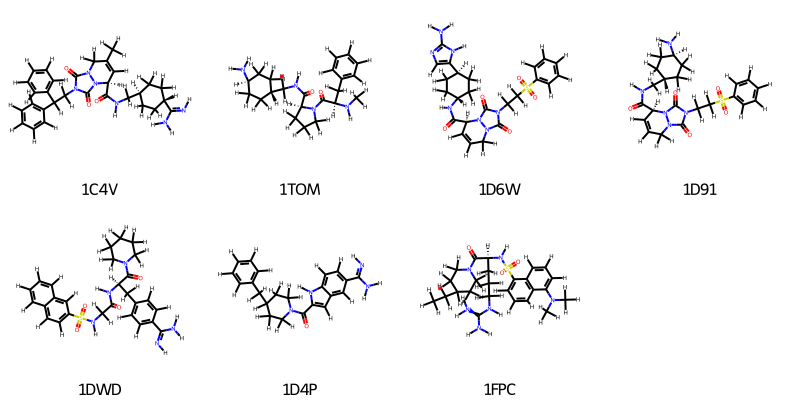

In [7]:
ligs_no_conf = [
    Chem.Mol(lig) for lig in pharmacophore.ligands
]
for lig in ligs_no_conf:
    lig.RemoveAllConformers()
Draw.MolsToGridImage(ligs_no_conf, legends=legends, molsPerRow=4)

In [8]:
# Save conformers to file
if not os.path.isfile(conf_file):
    writer = Chem.SDWriter("./thrombin_ligands.sdf")
    for lig in pharmacophore.ligands:
        for conf in range(lig.GetNumConformers()):
            writer.write(lig, confId=conf)
    writer.close()

## View 3D structures

In [9]:
lig_ind = 2
conf_ind = 2
nv.show_rdkit(pharmacophore.ligands[lig_ind], conf_ind=conf_ind)

NGLWidget()

## Chemical features

We find chemical features in the ligands and visualize them.

In [11]:
pharmacophore.find_chem_feats()
pprint(pharmacophore.feats)

[{'A': [(12,), (20,), (23,)],
  'D': [(1,), (10,), (39,)],
  'H': [(3, 4, 5, 6, 7, 8), (38,)],
  'N': [],
  'P': [(2, 1, 39)],
  'R': [(17, 18, 19, 21, 22),
        (26, 27, 28, 29, 30, 31),
        (32, 33, 34, 35, 36, 37)]},
 {'A': [(1,), (27,), (11,), (18,)],
  'D': [(1,), (19,), (27,)],
  'H': [(21, 22, 23, 24, 25, 26), (13, 14, 15), (0,)],
  'N': [],
  'P': [(1,), (27,)],
  'R': [(4, 5, 6, 7, 8, 9)]},
 {'A': [(33,), (7,), (8,), (13,), (21,), (23,)],
  'D': [(24,), (35,), (36,)],
  'H': [(25, 26, 27, 28, 29, 30), (15, 16, 17)],
  'N': [],
  'P': [],
  'R': [(11, 12, 14, 19, 20), (31, 32, 33, 34, 35), (0, 1, 2, 3, 4, 5)]},
 {'A': [(32,), (7,), (8,), (13,), (21,), (23,)],
  'D': [(24,), (32,)],
  'H': [(26, 27, 28, 29, 30, 31), (15, 16, 17)],
  'N': [],
  'P': [(32,)],
  'R': [(11, 12, 14, 19, 20), (0, 1, 2, 3, 4, 5)]},
 {'A': [(1,), (12,), (21,), (25,), (26,)],
  'D': [(1,), (19,), (23,), (37,)],
  'H': [(14, 15, 16), (18, 17, 16)],
  'N': [],
  'P': [(2, 1, 37)],
  'R': [(3, 4, 5, 

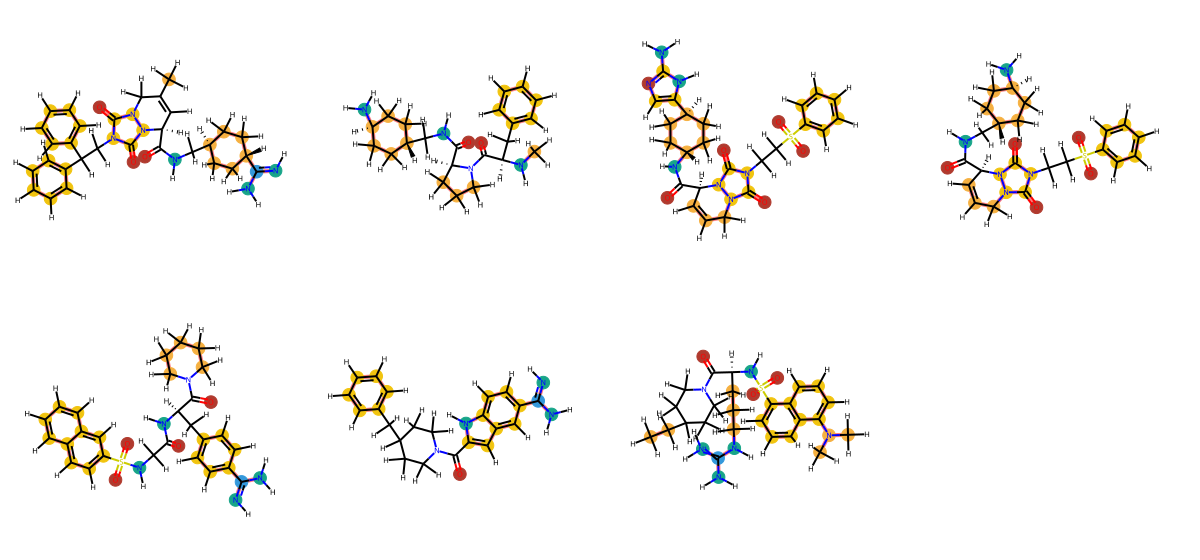

In [12]:
drawing = pharmacophore.draw((300, 280))
SVG(drawing.GetDrawingText())

## Extracting common pharmacophores

We extract common pharmacophores via recursive distance partitioning algorithm

In [10]:
import openpharmacophore.pharmacophore.ligand_based.rdp as rdp

In [13]:
RMSD = {}

In [14]:
def rdp_ligands(pharmacophore):
    rdp_ligs = []
    for ii, lig in enumerate(pharmacophore.ligands):
        lig = rdp.Ligand(lig, pharmacophore.feats[ii])
        lig._update_variant()
        rdp_ligs.append(lig)
        
    return rdp_ligs

In [15]:
def add_pharmacophore_to_view(view, points):
    for p in points:
        p.add_to_ngl_view(view)

In [16]:
def starting_boxes(ligs, n_pnts, min_act):
    k_variants = rdp.common_k_point_variants(ligs, n_pnts, min_act)
    return rdp.common_k_point_feature_lists(ligs, k_variants)

In [17]:
def find_cps(boxes, min_act, n_ligs):
    top_queue = []
    scores = {}
    for box in boxes:
        surviving_boxes = rdp.pharmacophore_partitioning(box, min_actives, len(ligands))
        n_boxes = len(surviving_boxes)
        print(f"Found {n_boxes} surviving boxes")
        for suv_box in surviving_boxes:
            top_representative = rdp.surviving_box_top_representative(suv_box, scores)
            # Check for uniqueness, score and max_pharmacophores
            rdp.add_feat_list_to_queue(top_queue, top_representative, max_pharmacophores)

    return [rdp.pharmacophore_from_feat_list(t) for t in top_queue]

### Finding 5-Point Pharmacophores

In [26]:
min_actives = len(pharmacophore.ligands) - 2
n_points = 5

In [27]:
rdp_ligs = rdp_ligands(pharmacophore)

In [28]:
boxes = starting_boxes(rdp_ligs, n_points, min_actives)
len(boxes)

49

In [29]:
pharmacophores = find_cps(boxes, min_actives, len(rdp_ligs))

Found 0 surviving boxes
Found 0 surviving boxes
Found 0 surviving boxes
Found 0 surviving boxes
Found 0 surviving boxes
Found 0 surviving boxes
Found 1 surviving boxes


IndexError: list index out of range

### Finding 3-Point Pharmacophores

In [15]:
min_actives = len(pharmacophore.ligands)
n_points = 3

rdp_ligs = rdp_ligands(pharmacophore)
boxes = surviving_boxes(rdp_ligs, min_actives, n_points)

# Print number of feature lists containers in each surviving box
print({v:len(b) for v, b in boxes.items()})

{'ADD': 13, 'ADR': 98, 'DDR': 13}


### Finding 4-Point Pharmacophores

In [17]:
min_actives = len(pharmacophore.ligands)
n_points = 4

rdp_ligs = rdp_ligands(pharmacophore)
boxes = surviving_boxes(rdp_ligs, min_actives, n_points)

# Print number of feature lists containers in each surviving box
print({v:len(b) for v, b in boxes.items()})

{'ADDR': 9}
